In [2]:
"""Vehicles Routing Problem (VRP)."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pylab
from matplotlib.pyplot import figure
import math
import pandas as pd
from scipy.spatial import distance


%matplotlib notebook
%matplotlib inline

sns.set(style="white", color_codes=True)


In [3]:
CARS =  5
POINTS = 200
STATION = 6
CAPACITY = 10000
TIME_END = 8 * 60 # минту # Допустим 60 км/ч

In [4]:
random.seed(41)
data = []
for i in range(POINTS):
    data.append( (random.randint(1,POINTS), random.randint(1,POINTS)) )
    
x = []
y = []
pandas_columns = ['points', 'money']
for i in data:
    val = str(i[0])+ ',' + str(i[1])
    if val in pandas_columns:
        new_x = random.randint(1,POINTS) 
        new_y = random.randint(1,POINTS) 
        x.append(new_x)
        y.append(new_y)
        val = str(new_x)+ ',' + str(new_y)
    else:        
        x.append(i[0])
        y.append(i[1])
        
        
    pandas_columns.append( val ) 
    


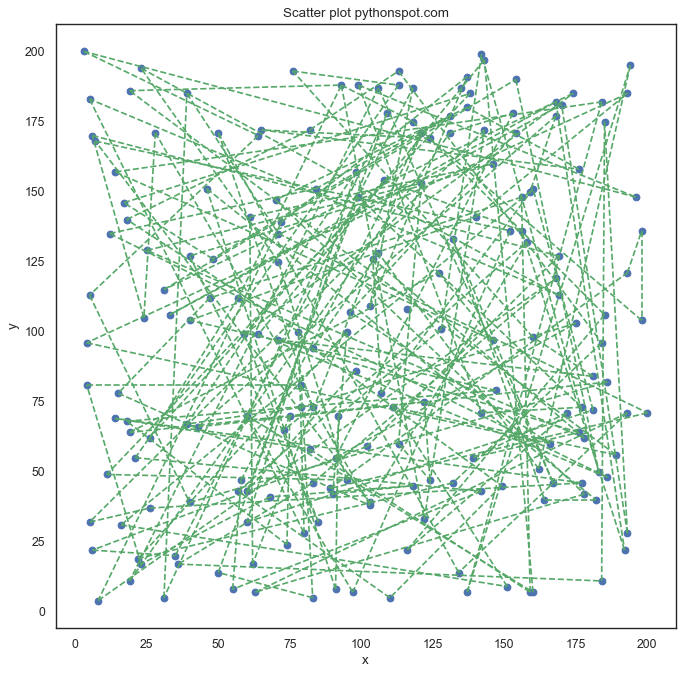

In [5]:
colors = (0,0,0)
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(x, y)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')

for i in range(POINTS):
    try:
        plt.plot(
            (data[i][0], data[i+1][0]),
            (data[i][1], data[i+1][1]), 
            'g--'
        )
    except IndexError:
        a=1


plt.show()

In [6]:
raw_data = pd.DataFrame(columns=pandas_columns)
raw_data['points'] = pandas_columns[2:]


In [7]:
def getValues(row, clm):
    probka = random.random()
    A = row['points'].split(',')
    B = clm.split(',')
    dst = distance.euclidean((int(A[0]), int(A[1])), (int(B[0]), int(B[1])) )
    #return (dst, probka)
    return dst

def getRandomMoney(row):
    return random.randint(100, 10000) 

def create_data_model(raw_data):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = raw_data.drop(['money', 'center'], axis=1).as_matrix()
    data['num_vehicles'] = 5
    data['depot'] = 0
    return data
    # [END data_model]

In [8]:
random.seed(42)
for p in pandas_columns[2:]:
    raw_data[p] = raw_data[['points',p]].apply(getValues,  axis=1, args = (p,) )

random.seed(42)
raw_data['money'] = raw_data[['money']].apply(getRandomMoney,  axis=1 )


In [9]:
raw_data.set_index('points', inplace=True)

In [10]:
raw_data['center'] = 0
raw_data.loc[data.index =='49,43', 'center'] =1
raw_data.loc[data.index =='30,50', 'center'] =1
raw_data.loc[data.index =='77,89', 'center'] =1
raw_data.loc[data.index =='13,31', 'center'] =1
raw_data.loc[data.index =='86,36', 'center'] =1
raw_data.loc[data['center'] == 1, 'money'] = 0

KeyError: 'cannot use a single bool to index into setitem'

In [ ]:
data = create_data_model(raw_data)

In [ ]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))


In [11]:

def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(raw_data)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        return data, manager, routing, solution
    else:
        return False


In [16]:
data_new, manager, routing, solution = main()

/Users/u17230836/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [18]:
print_solution(data_new, manager, routing, solution)

NameError: name 'print_solution' is not defined

In [19]:
max_route_distance = 0
vhc = {}
for vehicle_id in range(data_new['num_vehicles']):    
    index = routing.Start(vehicle_id)
    vhc[vehicle_id] =[]
    plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
    route_distance = 0
    while not routing.IsEnd(index):
        
        #vhc[index].append(manager.IndexToNode(index))
        plan_output += ' {} -> '.format(manager.IndexToNode(index))
        vhc[vehicle_id].append(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(
        previous_index, index, vehicle_id)
    vhc[vehicle_id].append(manager.IndexToNode(index))
    plan_output += '{}\n'.format(manager.IndexToNode(index))
    plan_output += 'Distance of the route: {}m\n'.format(route_distance)
    #print(plan_output)
    max_route_distance = max(route_distance, max_route_distance)

In [20]:
clss = {} 
clss[0] = 'b--'
clss[1] = 'g--'
clss[2] = 'r--' 
clss[3] = 'c--' 
clss[4] = 'm--' 
clss[5] = 'y--' 


In [21]:
def drawResult(x,y,new_data, show_text =False):
    colors = (0,0,0)
    figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(x, y)

    plt.title('Scatter plot pythonspot.com')
    plt.xlabel('x')
    plt.ylabel('y')
    
    if show_text == True:
        for i_x, i_y in zip(x, y):
            plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y))

    for v in vhc:
        clr_cur = clss[v]
        for  idx, elem in enumerate(vhc[v]):    
            try:
                xx1,yy1 = raw_data.index[vhc[v][idx]].split(',')
                xx2,yy2 = raw_data.index[vhc[v][idx+1]].split(',')
                xx1 = int(xx1)
                yy1 = int(yy1)
                xx2 = int(xx2)
                yy2 = int(yy2)
                plt.plot(
                    (xx1, xx2),
                    (yy1, yy2), 
                    clr_cur
                )
            except IndexError:
                a=1
        
    plt.show()

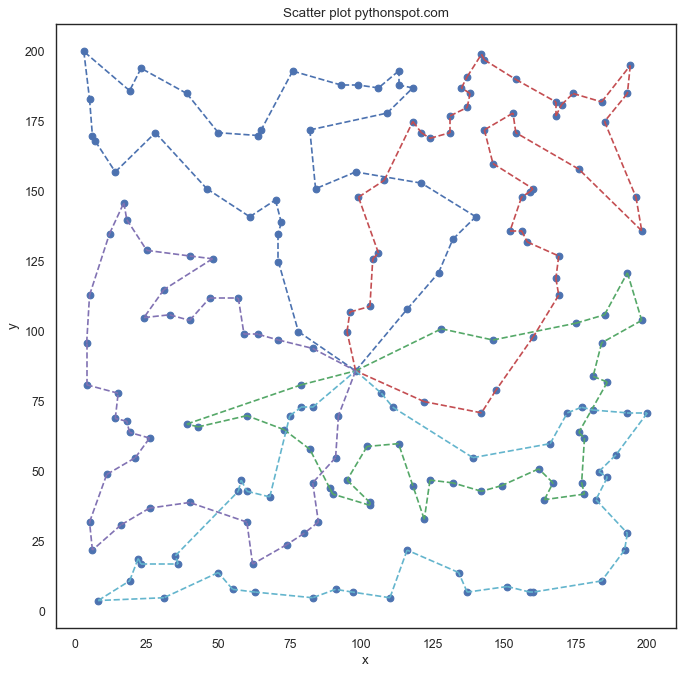

In [22]:
drawResult(x, y, raw_data, False)